NOT WORKING

# Notebook 25: Computing the SFR from Cruslinska et al. (2020)' SFRD data

Cruslinska et al. (2020) have made publicly available their calculate SFR density (SFRD) corrected for the non-universal IMF, for valid redshift-metallicity pairs between $z=0$ and $z=10$, and $[\mathrm{Fe/H}]\sim-4$ ($Z_\mathrm{O/H}\approx5.5$) and $[\mathrm{Fe/H}]\sim2$ ($Z_\mathrm{O/H}\approx10$). Were we able to calculate the SFR from this data, this would be a potentially simple method of constructing a physical SFR grid.

However, a complete "reconstruction" of a physical grid is not possible, once more, because of the need for the inclusion of dispersion. In the absence of dispersion, we would be able to utilize the relation $\mathrm{SFR} = \mathrm{SFRD} /\mathrm{GSMF}$. However, because the SFRD itself was already calculated with a dispersion that we cannot take into account, this is not possible. In particular, because we lose galaxies with the very highest and the very lowest metallicities at each redshift. 

Although this method is not employed, this notebook contains some exploration of the data from Cruslinska et al. (2020).

## Prelude

In [1]:
import numpy as np
import tables as tb
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import astropy.units as u
from math import isnan

import sys
sys.path.append('../src/')
from constants import Z_SUN
from zdf import NeijsselZDF, MetallicityPicker
from utils import FeH_to_Z, ZOH_to_FeH
from sfr import SFR

../src\constants.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  [9.00, (-2.38, -6.244125144, 10.54)]


In [2]:
ROOT = Path('..')
DATAFOLDER = Path(ROOT, 'Data')
C20_DATAPATH = Path(DATAFOLDER, 'C20_Results', 'SFRD_Z_z_data')

highmet_SFRD_DATA_PATH = Path(C20_DATAPATH, '302w14vIMF3aeh_FOH_z_dM.dat')
lowmet_SFRD_DATA_PATH = Path(C20_DATAPATH, '204w14vIMF3aeh_FOH_z_dM.dat')
REDSHIFT_DATA_PATH = Path(C20_DATAPATH, 'Time_redshift_deltaT.dat')

In [3]:
redshift_data = np.genfromtxt(REDSHIFT_DATA_PATH) # time(myr) redshift timestep(myr)
redshift_array = redshift_data[:,1]
dt_array = redshift_data[:, 2]

In [4]:
FOH_min, FOH_max = 5.3, 9.7
FOH_array = np.linspace(FOH_min,FOH_max, 200)
dZOH = FOH_array[1]-FOH_array[0]
Z_array = np.array([FeH_to_Z(ZOH_to_FeH(zoh)) for zoh in FOH_array])

In [5]:
lowmet_SFRD = np.genfromtxt(lowmet_SFRD_DATA_PATH)

for i, row in enumerate(lowmet_SFRD):
    for j, col in enumerate(row):
        try:
            dz = redshift_array[i]-redshift_array[i+1]
        except IndexError:
            dz = redshift_array[i]
        dt = dt_array[i]*1e6
        d3 = dZOH*dt
        lowmet_SFRD[i,j] /= d3

In [6]:
highmet_SFRD = np.genfromtxt(highmet_SFRD_DATA_PATH)

for i, row in enumerate(highmet_SFRD):
    for j, col in enumerate(row):
        try:
            dz = redshift_array[i]-redshift_array[i+1]
        except IndexError:
            dz = redshift_array[i]
        dt = dt_array[i]*1e6
        d3 = dZOH*dt
        highmet_SFRD[i,j] /= d3

In [7]:
def conditional_log10(x):
    if x <= 0:
        return np.nan
    else:
        return np.log10(x)
    
vec_conditional_log10 = np.vectorize(conditional_log10)
    
log_lowmet_SFRD = vec_conditional_log10(lowmet_SFRD)
log_highmet_SFRD = vec_conditional_log10(highmet_SFRD)

In [8]:
xx, yy = np.meshgrid(redshift_array, Z_array/Z_SUN)

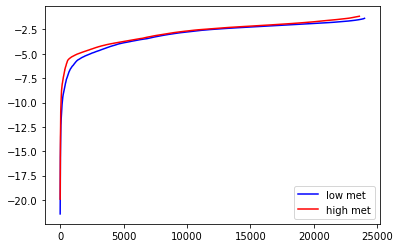

In [9]:
plt.plot(np.sort(log_lowmet_SFRD.flatten()), 'b-', markersize=1, label='low met')
plt.plot(np.sort(log_highmet_SFRD.flatten()), 'r-', markersize=1, label='high met')
plt.legend()

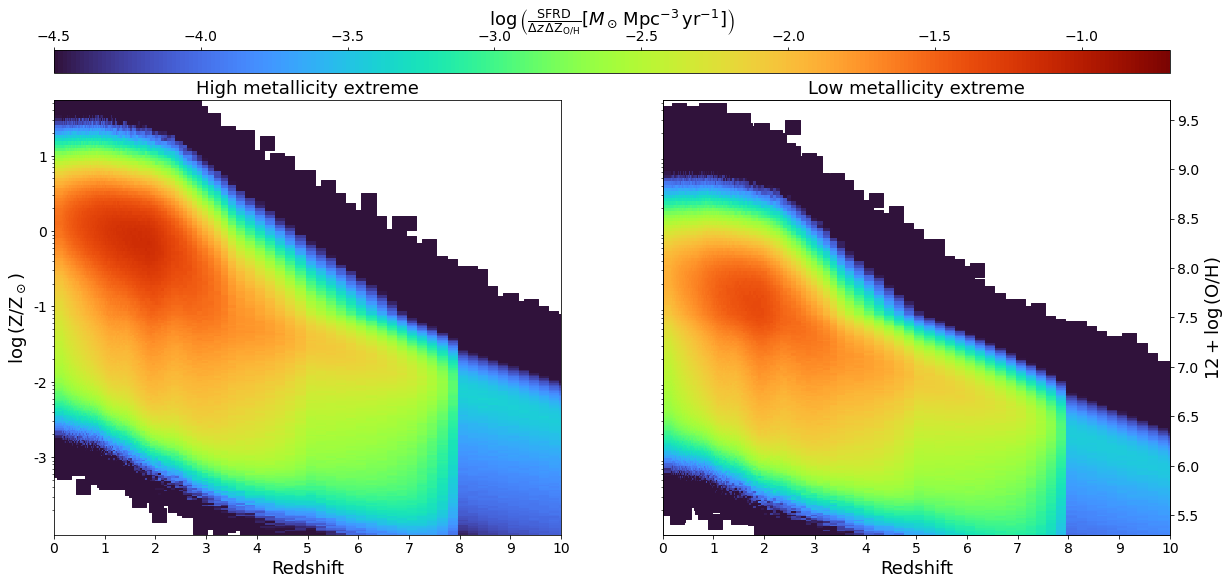

In [10]:
logSFRD = log_highmet_SFRD
vmin = -4.5
vmax = -0.7

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20,10))

ax1.scatter(xx, yy, c=logSFRD.T, cmap='turbo', vmin=vmin, vmax=vmax, s=200, marker='s')
ax1.set_yscale('log')

ax1.set_xlim(min(redshift_array), max(redshift_array))
ax1.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax1.set_xlabel('Redshift', fontsize=18)
ax1.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax1.set_yticks([10**x for x in np.arange(-3.,2.,1.)])
ax1.set_yticklabels([str(x) for x in np.arange(-3,2,1)])

ax1.set_xticks(np.arange(0,11,1))

ax1.tick_params(axis='both', labelsize=14)

ax1.set_title('High metallicity extreme', fontsize=18)


##################################


logSFRD = log_lowmet_SFRD

ax2.scatter(xx, yy, c=logSFRD.T, cmap='turbo', vmin=vmin, vmax=vmax, s=200, marker='s')
ax2.set_yscale('log')

ax2.set_xlim(min(redshift_array), max(redshift_array))
ax2.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax2.set_xlabel('Redshift', fontsize=18)
#ax2.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xticks(np.arange(0,11,1))

ax2.tick_params(axis='both', labelsize=14)

ax2.set_title('Low metallicity extreme', fontsize=18)

ax22 = ax2.twinx()

ax22.set_ylabel(r'$12+\log\left(\mathrm{O}/\mathrm{H}\right)$', fontsize=18)
ax22.set_ylim(FOH_min, FOH_max)
ax22.tick_params(axis='both', labelsize=14)


######################


sm = cm.ScalarMappable(cmap=cm.turbo, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, location='top', aspect=50, ax = [ax1, ax2])
cb.set_label(label=r'$\log\left(\frac{\mathrm{SFRD}}{\Delta z\,\Delta\mathrm{Z}_{\mathrm{O}/\mathrm{H}}}[M_\odot\,\mathrm{Mpc}^{-3}\,\mathrm{yr}^{-1}]\right)$', size=18)
cb.ax.tick_params(labelsize=14)

#### From the SFRD to the SFR

We now have the SFR _density_ on hand as a function of metallicity and redshift. In order to obtain the SFR of an individual galaxy of a given metallcity and at a given redshift, we now need only to multiply the SFRD by the comoving volume of that redshift shell and divide by the number of galaxies of that metallicity it contains; or, equivalently, to divide the SFRD by the number density of galaxies at that $z,Z$. This quantity is given by the _galaxy stellar mass function_, or GSMF.

In [11]:
from imf import GSMF

Text(0.5, 1.0, 'Galactic stellar mass function (GSMF)')

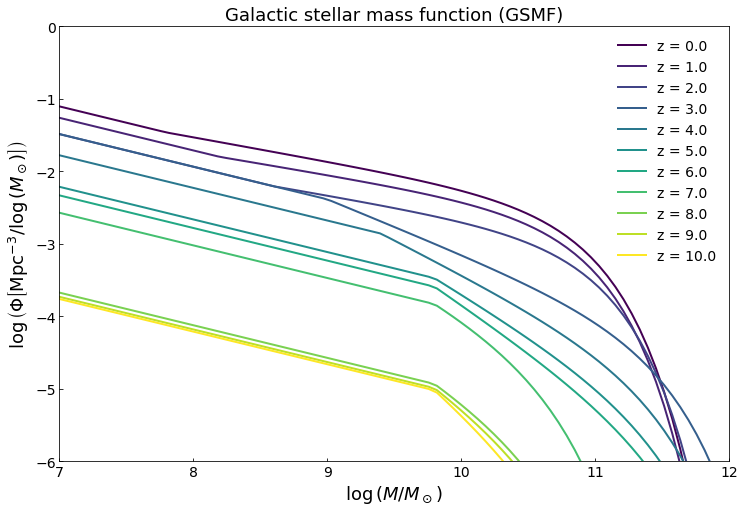

In [12]:
test_zs = np.arange(0, 11, 1.)
test_masses = np.linspace(6, 12, 100)

fig, ax = plt.subplots(figsize=(12,8))
color_norm = test_zs.max()-test_zs.min()

for z in test_zs:
    gsmf = GSMF(z)
    gsmfs = np.array([gsmf.gsmf(m) for m in test_masses])
    
    color = cm.viridis(z/color_norm)
    ax.plot(test_masses, gsmfs, '-', c=color, label=f'z = {z}', lw=2)
    
ax.legend(loc='upper right', frameon=False, fontsize=14)

ax.set_ylim(-6, 0)
ax.set_xlim(7, 12)
ax.tick_params(axis='both', labelsize=14, direction='in')

ax.set_xlabel(r'$\log\left(M/M_\odot\right)$', fontsize=18)
ax.set_ylabel(r'$\log\left(\Phi\left[\mathrm{Mpc}^{-3}/\log\left(M_\odot\right)\right]\right)$', fontsize=18)
ax.set_title('Galactic stellar mass function (GSMF)', fontsize=18)

In [13]:
log_lowmet_SFR = np.empty(lowmet_SFRD.shape, np.float64)

for i, row in enumerate(log_lowmet_SFR):
    for j, col in enumerate(row):
        try:
            z2 = redshift_array[i]
            z1 = redshift_array[i+1]
        except IndexError:
            z2 = redshift_array[i]
            z1 = 0
        zoh = FOH_array[j]
        sfr = SFR(z2, zoh)
        sfr._set_gsmf_mzr()
        sfr._solve_density()
        logn = np.float64(sfr.log_dn_dm)
        dz = z2 - z1
        dz = dz
        log_lowmet_SFR[i,j] = np.log10(lowmet_SFRD[i,j] * dZOH*dz) - logn

../src\sfr.py:264: RuntimeWarning: invalid value encountered in double_scalars
  return self.m_to * (10**(self.z_a-zoh+dz)-1)**(-1/self.gamma)
C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
../src\sfr.py:261: RuntimeWarning: invalid value encountered in double_scalars
  return self.m_to * (10**(self.z_a-zoh)-1)**(-1/self.gamma)


In [ ]:
log_highmet_SFR = np.empty(highmet_SFRD.shape, np.float64)
log_highmet_n = np.empty(highmet_SFRD.shape, np.float64)

for i, row in enumerate(log_highmet_SFR):
    for j, col in enumerate(row):
        try:
            z2 = redshift_array[i]
            z1 = redshift_array[i+1]
        except IndexError:
            z2 = redshift_array[i]
            z1 = 0
        zoh = FOH_array[j]
        sfr = SFR(z2, zoh, 'KK04')
        sfr._set_gsmf_mzr()
        sfr._solve_density()
        logn = np.float64(sfr.log_dn_dm)
        dz = z2 - z1
        dz = dz
        log_highmet_n[i,j] = logn
        log_highmet_SFR[i,j] = np.log10(highmet_SFRD[i,j] * dZOH*dz) - logn

In [ ]:
#plt.plot(np.sort(log_lowmet_SFR.flatten()), 'b-', markersize=1, label='low met')
plt.plot(np.sort(log_highmet_SFR.flatten()), 'r-', markersize=1, label='high met')
plt.ylim(-10,15)
plt.legend()

In [ ]:
logSFR = log_highmet_SFR
vmin = -5
vmax = 12


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20,10))

ax1.scatter(xx, yy, c=logSFR.T, cmap='turbo', vmin=vmin, vmax=vmax, s=90, marker='s')
ax1.set_yscale('log')

ax1.set_xlim(min(redshift_array), max(redshift_array))
ax1.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax1.set_xlabel('Redshift', fontsize=18)
ax1.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax1.set_yticks([10**x for x in np.arange(-3.,2.,1.)])
ax1.set_yticklabels([str(x) for x in np.arange(-3,2,1)])

ax1.set_xticks(np.arange(0,11,1))

ax1.tick_params(axis='both', labelsize=14)

ax1.set_title('High metallicity extreme', fontsize=18)


##################################


#logSFR = log_lowmet_SFR

ax2.scatter(xx, yy, c=logSFR.T, cmap='turbo', vmin=vmin, vmax=vmax, s=90, marker='s')
ax2.set_yscale('log')

ax2.set_xlim(min(redshift_array), max(redshift_array))
ax2.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax2.set_xlabel('Redshift', fontsize=18)
#ax2.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xticks(np.arange(0,11,1))

ax2.tick_params(axis='both', labelsize=14)

ax2.set_title('Low metallicity extreme', fontsize=18)

ax22 = ax2.twinx()

ax22.set_ylabel(r'$12+\log\left(\mathrm{O}/\mathrm{H}\right)$', fontsize=18)
ax22.set_ylim(FOH_min, FOH_max)
ax22.tick_params(axis='both', labelsize=14)


######################


sm = cm.ScalarMappable(cmap=cm.turbo, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, location='top', aspect=50, ax = [ax1, ax2])
cb.set_label(label=r'$\log\left(\mathrm{SFR}[M_\odot\,\mathrm{yr}^{-1}]\right)$', size=18)
cb.ax.tick_params(labelsize=14)

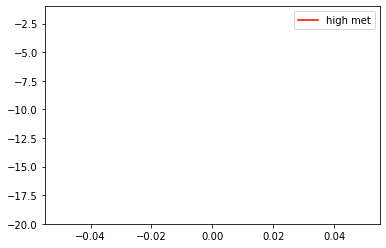

In [27]:
#plt.plot(np.sort(log_lowmet_SFR.flatten()), 'b-', markersize=1, label='low met')
plt.plot(np.sort(log_highmet_n.flatten()), 'r-', markersize=1, label='high met')
plt.ylim(-20, -1)
plt.legend()

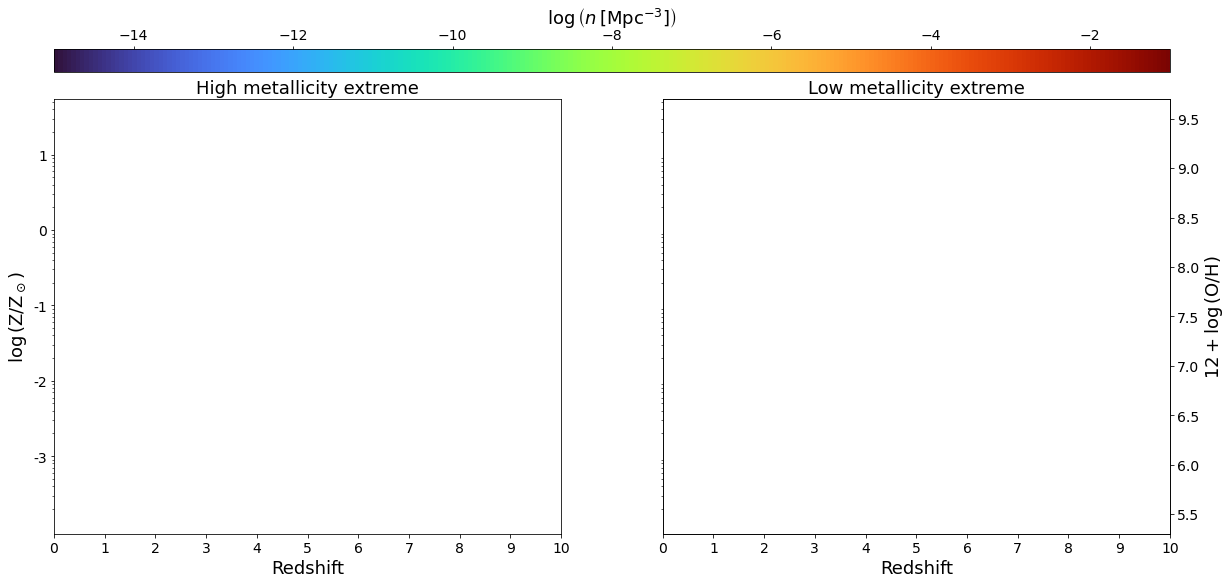

In [28]:
logSFR = log_highmet_n
vmin = -15
vmax = -1


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20,10))

ax1.scatter(xx, yy, c=logSFR.T, cmap='turbo', vmin=vmin, vmax=vmax, s=90, marker='s')
ax1.set_yscale('log')

ax1.set_xlim(min(redshift_array), max(redshift_array))
ax1.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax1.set_xlabel('Redshift', fontsize=18)
ax1.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax1.set_yticks([10**x for x in np.arange(-3.,2.,1.)])
ax1.set_yticklabels([str(x) for x in np.arange(-3,2,1)])

ax1.set_xticks(np.arange(0,11,1))

ax1.tick_params(axis='both', labelsize=14)

ax1.set_title('High metallicity extreme', fontsize=18)


##################################


#logSFR = log_lowmet_SFR

ax2.scatter(xx, yy, c=logSFR.T, cmap='turbo', vmin=vmin, vmax=vmax, s=90, marker='s')
ax2.set_yscale('log')

ax2.set_xlim(min(redshift_array), max(redshift_array))
ax2.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax2.set_xlabel('Redshift', fontsize=18)
#ax2.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xticks(np.arange(0,11,1))

ax2.tick_params(axis='both', labelsize=14)

ax2.set_title('Low metallicity extreme', fontsize=18)

ax22 = ax2.twinx()

ax22.set_ylabel(r'$12+\log\left(\mathrm{O}/\mathrm{H}\right)$', fontsize=18)
ax22.set_ylim(FOH_min, FOH_max)
ax22.tick_params(axis='both', labelsize=14)


######################


sm = cm.ScalarMappable(cmap=cm.turbo, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, location='top', aspect=50, ax = [ax1, ax2])
cb.set_label(label=r'$\log\left(n\,[\mathrm{Mpc}^{-3}]\right)$', size=18)
cb.ax.tick_params(labelsize=14)

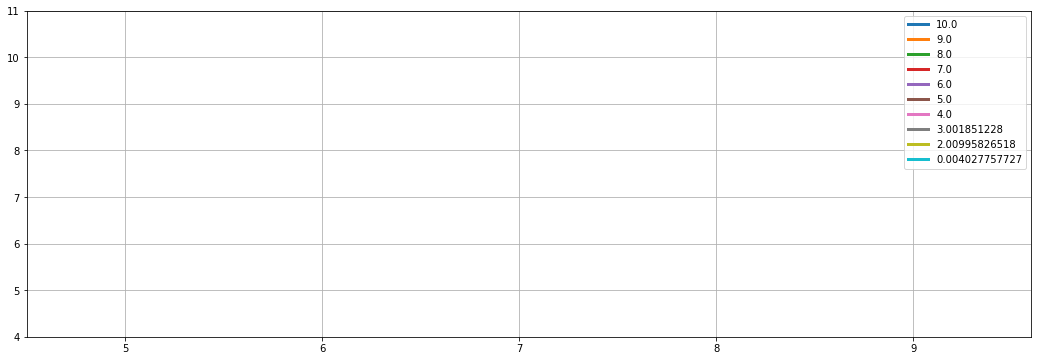

In [29]:
fig, ax = plt.subplots(figsize=(18,6))

for sfzr, z in zip(log_highmet_SFR, redshift_array):
    if z%1<=1e-2:
        ax.plot(FOH_array, sfzr, '-', label=z, lw=3)
    
ax.set_ylim(4,11)
ax.set_xlim(4.5, 9.6)
ax.legend()
ax.grid(visible=True)

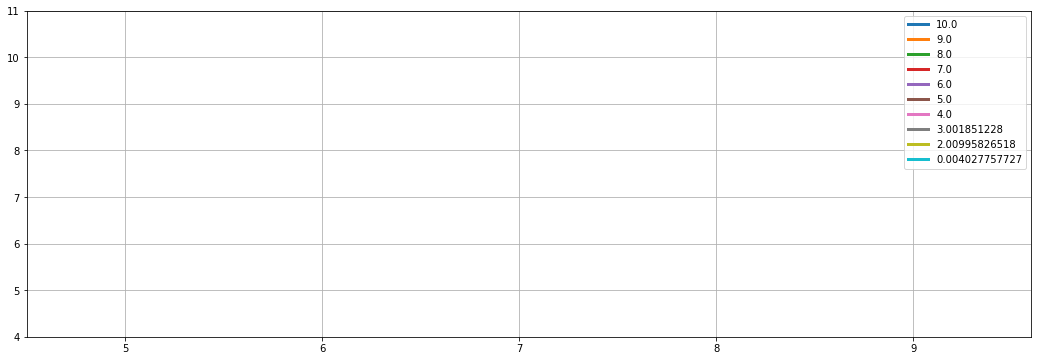

In [30]:
fig, ax = plt.subplots(figsize=(18,6))

for sfzr, z in zip(log_highmet_n, redshift_array):
    if z%1<=1e-2:
        ax.plot(FOH_array, sfzr, '-', label=z, lw=3)
    
ax.set_ylim(4,11)
ax.set_xlim(4.5, 9.6)
ax.legend()
ax.grid(visible=True)

#### Metallicity-redshift relation

In [31]:
m = 5
zdfs = np.empty((0, m+m%2), np.float64)
zdf_choices = np.empty((0, m+m%2), np.float64)

redshift_choices = np.linspace(0,10,11)

for z in redshift_choices:
    zdf = NeijsselZDF(z, logZ=True)
    picker = MetallicityPicker(zdf, m)
    metallicities = picker.get_metallicities()
    zdfs = np.append(zdfs, zdf)
    zdf_choices = np.append(zdf_choices, metallicities.reshape(1, m+m%2), axis=0)

Optimization terminated successfully.
         Current function value: -1.022928
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: -1.022914
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: -1.022922
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -1.022905
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: -1.022920
         Iterations: 24
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: -1.022928
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -1.022915
         Iterations: 27
         Function evaluations: 54
Optimization terminated suc

../src\zdf.py:112: RuntimeWarning: invalid value encountered in log
  exp = np.exp(-(np.log(metallicity)-self.mu)**2/(2*self.sigma**2))


In [32]:
mets_xx = np.repeat(redshift_choices.reshape(redshift_choices.shape[0], 1), repeats=m+m%2, axis=1)
mets_yy = zdf_choices

mets_plot = np.array([mets_xx.flatten(), mets_yy.flatten()]).T

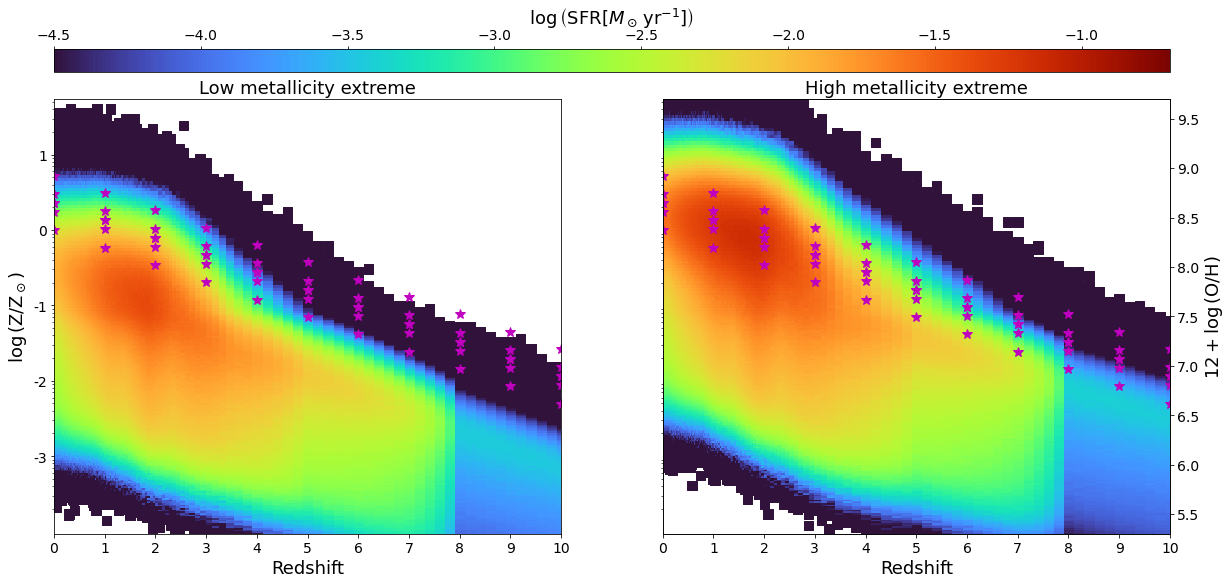

In [33]:
logSFR = log_lowmet_SFRD
vmin = -4.5
vmax = -0.7


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20,10))

ax1.scatter(xx, yy, c=logSFR.T, cmap='turbo', vmin=vmin, vmax=vmax, s=90, marker='s')
ax1.set_yscale('log')

ax1.set_xlim(min(redshift_array), max(redshift_array))
ax1.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax1.set_xlabel('Redshift', fontsize=18)
ax1.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax1.set_yticks([10**x for x in np.arange(-3.,2.,1.)])
ax1.set_yticklabels([str(x) for x in np.arange(-3,2,1)])

ax1.set_xticks(np.arange(0,11,1))

ax1.tick_params(axis='both', labelsize=14)

ax1.set_title('Low metallicity extreme', fontsize=18)


##################################


logSFR = log_highmet_SFRD

ax2.scatter(xx, yy, c=logSFR.T, cmap='turbo', vmin=vmin, vmax=vmax, s=90, marker='s')
ax2.set_yscale('log')

ax2.set_xlim(min(redshift_array), max(redshift_array))
ax2.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax2.set_xlabel('Redshift', fontsize=18)
#ax2.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xticks(np.arange(0,11,1))

ax2.tick_params(axis='both', labelsize=14)

ax2.set_title('High metallicity extreme', fontsize=18)

ax22 = ax2.twinx()

ax22.set_ylabel(r'$12+\log\left(\mathrm{O}/\mathrm{H}\right)$', fontsize=18)
ax22.set_ylim(FOH_min, FOH_max)
ax22.tick_params(axis='both', labelsize=14)


######################


sm = cm.ScalarMappable(cmap=cm.turbo, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, location='top', aspect=50, ax = [ax1, ax2])
cb.set_label(label=r'$\log\left(\mathrm{SFR}[M_\odot\,\mathrm{yr}^{-1}]\right)$', size=18)
cb.ax.tick_params(labelsize=14)


################

color_norm = redshift_choices.max()-redshift_choices.min()

ax1.plot(mets_plot[:,0], mets_plot[:,1]/Z_SUN, 'm*', markersize=10)
ax2.plot(mets_plot[:,0], mets_plot[:,1]/Z_SUN, 'm*', markersize=10)

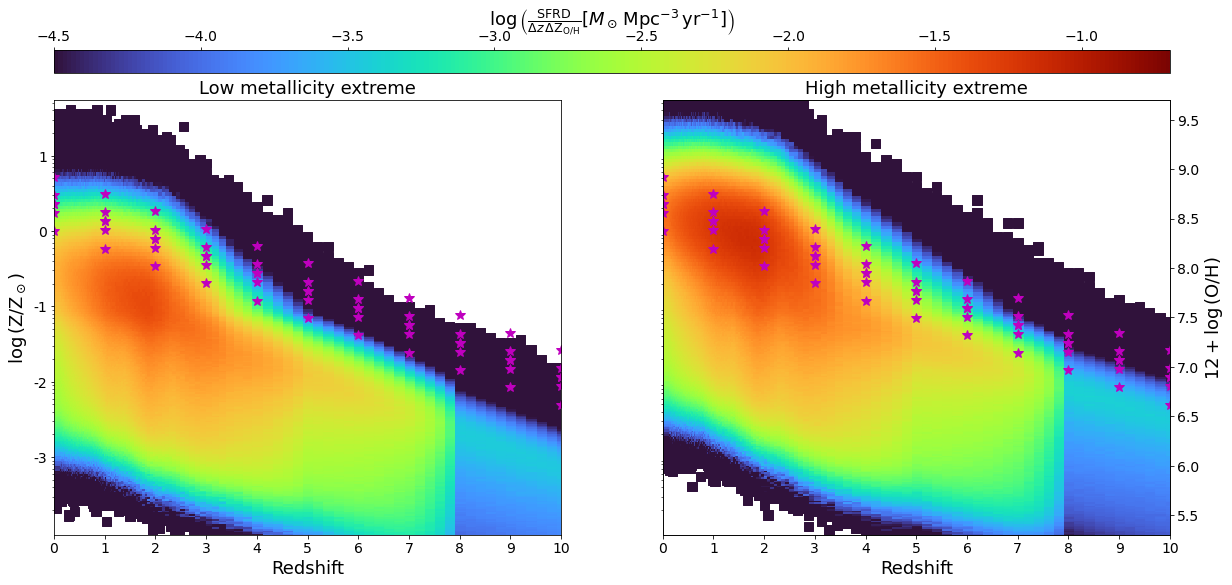

In [34]:
logSFR = log_lowmet_SFRD
vmin = -4.5
vmax = -0.7


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20,10))

ax1.scatter(xx, yy, c=logSFR.T, cmap='turbo', vmin=vmin, vmax=vmax, s=90, marker='s')
ax1.set_yscale('log')

ax1.set_xlim(min(redshift_array), max(redshift_array))
ax1.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax1.set_xlabel('Redshift', fontsize=18)
ax1.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax1.set_yticks([10**x for x in np.arange(-3.,2.,1.)])
ax1.set_yticklabels([str(x) for x in np.arange(-3,2,1)])

ax1.set_xticks(np.arange(0,11,1))

ax1.tick_params(axis='both', labelsize=14)

ax1.set_title('Low metallicity extreme', fontsize=18)


##################################


logSFR = log_highmet_SFRD

ax2.scatter(xx, yy, c=logSFR.T, cmap='turbo', vmin=vmin, vmax=vmax, s=90, marker='s')
ax2.set_yscale('log')

ax2.set_xlim(min(redshift_array), max(redshift_array))
ax2.set_ylim(Z_array.min()/Z_SUN, Z_array.max()/Z_SUN)
ax2.set_xlabel('Redshift', fontsize=18)
#ax2.set_ylabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xticks(np.arange(0,11,1))

ax2.tick_params(axis='both', labelsize=14)

ax2.set_title('High metallicity extreme', fontsize=18)

ax22 = ax2.twinx()

ax22.set_ylabel(r'$12+\log\left(\mathrm{O}/\mathrm{H}\right)$', fontsize=18)
ax22.set_ylim(FOH_min, FOH_max)
ax22.tick_params(axis='both', labelsize=14)


######################


sm = cm.ScalarMappable(cmap=cm.turbo, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, location='top', aspect=50, ax = [ax1, ax2])
cb.set_label(label=r'$\log\left(\frac{\mathrm{SFRD}}{\Delta z\,\Delta\mathrm{Z}_{\mathrm{O}/\mathrm{H}}}[M_\odot\,\mathrm{Mpc}^{-3}\,\mathrm{yr}^{-1}]\right)$', size=18)
cb.ax.tick_params(labelsize=14)


################

color_norm = redshift_choices.max()-redshift_choices.min()

ax1.plot(mets_plot[:,0], mets_plot[:,1]/Z_SUN, 'm*', markersize=10)
ax2.plot(mets_plot[:,0], mets_plot[:,1]/Z_SUN, 'm*', markersize=10)

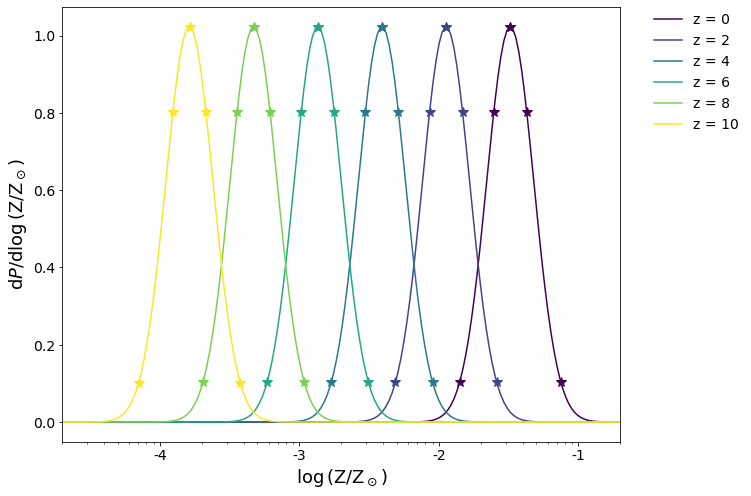

In [35]:
plot_Zs = np.logspace(-3, 1.2, 200)*Z_SUN

fig, ax = plt.subplots(figsize=(10,8))
color_norm = redshift_choices.max()-redshift_choices.min()

for redshift, zdf, choices in zip(redshift_choices[::2], zdfs[::2], zdf_choices[::2]):
    color = cm.viridis((redshift-redshift_choices.min())/color_norm)
    ax.plot(choices, zdf.zdf(choices), '*', c=color, markersize=10)
    ax.plot(plot_Zs, zdf.zdf(plot_Zs), c=color, label=f'z = {redshift:.0f}')
    
ax.set_xscale('log')

ax.set_xlim(2e-5, 2e-1)
ax.set_xlabel(r'$\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\log\left(\mathrm{Z}/\mathrm{Z}_\odot\right)$', fontsize=18)

ax.set_xticks([10**x for x in np.arange(-4, 0, 1.)])
ax.set_xticklabels(np.arange(-4, 0, 1))

ax.tick_params(axis='both', labelsize=14)

ax.legend(loc=(1.05,0.7), frameon=False, fontsize=14)